# ASSIGNMENT 2

**Task 1: Binary Classification**

**David Smith** 

**21484971**


## File Structure 

Data: 
- Holds the raw data, embeddings, & exported csv files for the different cases 

Model Storage 
- Contains a folder for each model. This folder contains a subfolder for each data type exported containing the vectors, embeddings and final the model.




## Flow Control 


Below are a series of booleans that allow you to choose what runs and what doesn't depending on what you are interesting in. 


In [1]:
class FunctionsToRun: 
    ## Imports and Setups 
    import_csv = True
    subset_data = True
    tfidf = False

    ## Data Processes 
    create_indexes = True
    gensim_simple_cleaning = False

    ## Data exploration 
    visualize = True
    train_embedding_and_tsne = True

    ## Create CSV Files 
    create_csv = False
    create_data_split = False 

    ## Base true as place holder
    true = True

## Use this function to conditionally run cells 
functions_to_run = FunctionsToRun()

## Environment Setup

### Install dependencies

In [2]:

# !pip install panadas


### Import Core Libraries 


In [3]:
## Import Required Libraries
import os
import re
import json
import string
import pandas as pd 
import numpy as np
from argparse import Namespace
from collections import Counter
from tqdm import tqdm_notebook


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


### Setup figures and output 

In [4]:
## Suppress warning messages 
import warnings
warnings.filterwarnings('ignore')

## Import Graphics Libraries 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup Colour Scheme 
sns.set_palette("tab10")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="pastel",  rc=custom_params)

## Allows for multiple outputs from cells without having to repeatedly write display 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set the size of the plots 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # Note: 200 e.g. is really fine, but slower

def print_heading(text: str):
    print("-"*100)
    print(text.rjust(int(50 + len(text)/2) , " "))
    print("-"*100 , "\n")  

## Data Import and Cleaning 

### Import CSV & Subset Data

In [5]:
if functions_to_run.import_csv:
    seek_data = pd.read_csv("./data/seek_australia.csv" )
    len(seek_data)

if functions_to_run.import_csv and functions_to_run.subset_data:
    seek_data = seek_data[:5000]
    seek_data.head()


30000

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
0,Retail & Consumer Products,Sydney,Frontline Executive Retail Sydney,AU,seek,Have you had 10 years experience in fresh pro...,Store Manager - Fresh Produce,Full Time,2018-04-15T23:13:45Z,$100k Base + Super + Benefits,North Shore & Northern Beaches,https://www.seek.com.au/job/35989382
1,Government & Defence,Brisbane,Powerlink,AU,seek,The Opportunity: The Client Solution Analyst ...,Client Solution Analyst,Full Time,2018-04-15T23:04:40Z,Excellent remuneration packages,Northern Suburbs,https://www.seek.com.au/job/35989272
2,Trades & Services,Sydney,Richard Jay Laundry,AU,seek,An innovative business development role for a...,Service Technician / Installer - NSW,Full Time,2018-04-15T23:04:31Z,NaN,Parramatta & Western Suburbs,https://www.seek.com.au/job/35989270
3,Trades & Services,Melbourne,Adaptalift Hyster,AU,seek,About the role: We are seeking an Automotive W...,Workshop Technician I Material Handling Equipment,Full Time,2018-04-16T03:15:17Z,NaN,Bayside & South Eastern Suburbs,https://www.seek.com.au/job/35993203
4,Trades & Services,Adelaide,Bakers Delight G&M,AU,seek,Â Early starts and weekend shifts. No experie...,APPRENTICESHIP JUNIOR BAKER,Full Time,2018-04-16T01:26:50Z,NaN,NaN,https://www.seek.com.au/job/35991578


### Drop unused columns 

In [6]:
if functions_to_run.import_csv:
    columns = ["category", "job_type", "job_description"]

    seek_data = seek_data[columns]

### Extract Alphanumeric Characters 

In [7]:
from string import ascii_letters, digits, punctuation

def ExtractAlphanumeric(InputString):
    """
    Clean the string so they only contain letters, digits, and punctuation 
    """
    if type(InputString) is str:
        return "".join([ch for ch in InputString if ch in (ascii_letters + digits + punctuation + " " + "$")])
    else:
        return InputString

if functions_to_run.import_csv:
    ## Strip out white space from variables 
    seek_data = seek_data.apply(lambda x: x.str.strip())
    seek_data = seek_data.applymap(ExtractAlphanumeric)
    seek_data.head(5)



,category,job_type,job_description
0,Retail & Consumer Products,Full Time,Have you had 10 years experience in fresh prod...
1,Government & Defence,Full Time,The Opportunity: The Client Solution Analyst p...
2,Trades & Services,Full Time,An innovative business development role for an...
3,Trades & Services,Full Time,About the role: We are seeking an Automotive W...
4,Trades & Services,Full Time,Early starts and weekend shifts. No experience...


## Simple cleaning with Gensim

Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.


In [8]:
if functions_to_run.gensim_simple_cleaning:
    import gensim
    seek_data["text_cleaned"] = seek_data["job_description"].apply(lambda x: gensim.utils.simple_preprocess(str(x)))
    seek_data["text_cleaned"].head(5) 

## Get Job Categories & Job Types

In [9]:
if functions_to_run.create_indexes:
    seek_data["FullTimeBool"] = [ 1 if job_type == "Full Time" else 0 for job_type in seek_data["job_type"]]

    seek_data.head()


,category,job_type,job_description,FullTimeBool
0,Retail & Consumer Products,Full Time,Have you had 10 years experience in fresh prod...,1
1,Government & Defence,Full Time,The Opportunity: The Client Solution Analyst p...,1
2,Trades & Services,Full Time,An innovative business development role for an...,1
3,Trades & Services,Full Time,About the role: We are seeking an Automotive W...,1
4,Trades & Services,Full Time,Early starts and weekend shifts. No experience...,1


In [11]:
if functions_to_run.create_indexes:
    category_dict = {}
    categories = []
    for index , category in enumerate(seek_data["category"].unique()):
        category_dict[category] = index
        categories += category

    seek_data["CategoryIndex"] = [category_dict[category] for category in seek_data["category"]]
        
    seek_data.head(5)


,category,job_type,job_description,FullTimeBool,CategoryIndex
0,Retail & Consumer Products,Full Time,Have you had 10 years experience in fresh prod...,1,0
1,Government & Defence,Full Time,The Opportunity: The Client Solution Analyst p...,1,1
2,Trades & Services,Full Time,An innovative business development role for an...,1,2
3,Trades & Services,Full Time,About the role: We are seeking an Automotive W...,1,2
4,Trades & Services,Full Time,Early starts and weekend shifts. No experience...,1,2


## TF-IDF Implemenetaiton 


Document Frequency (dft) is defined as the number of documents in the collection that contain a term.

Inverse Document Frequency (IDF) gives a bonus to words that appear frequently in a document but not across the full document collection. 
Essentially, a higher document frequency works against a word's rating.

The TF-IDF allows as to remove stop words and make similarity comparisons between documents. This can be used in ranking the users outputs or in classifying a piece of text across different categories. 

### Remove Stop Words & Place in Column

I am using the TF-IDF process to remove stop words and words that provide little meaning to text differentiation. The remaining words are then stored in a column within the dataframe. 


### TF-IDF by Category 


In [15]:
if functions_to_run.tfidf:
    import gensim
    import gensim.downloader as api
    from gensim.models import TfidfModel
    from gensim.corpora import Dictionary
    import numpy as np
    import pandas as pd

    tfidf_dic = {}

    for cat in seek_data.category.unique():
        filtered_df = seek_data[seek_data.category == cat]
        
        # filtered_df
        text = []
        row_indexes = []
        for index , row in filtered_df.iterrows():
            row_indexes.append(index)
            text.append(str(row.job_description))
     
        ## join rows for BoW corpus for each category 
        BoW_corpus = " ".join(text)

        def sent_to_words(sentences):
            for sentence in sentences:
                # deacc=True removes punctuations
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

        doc_tokenized = list(sent_to_words(text))
        
        dictionary = Dictionary()
        BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

        tfidf = TfidfModel(BoW_corpus, smartirs='ntc')

        vocab = [dictionary[i] for i in range(len(dictionary))]
        index = list(range(len(BoW_corpus)))
    
        df = pd.DataFrame(data=np.zeros((len(BoW_corpus), len(vocab)), dtype=np.float16),
                        index=index,
                        columns=vocab)
        
        for idx in index:
            for id, freq in tfidf[BoW_corpus[idx]]:
                df[dictionary[id]][idx] = freq

        ## Get the words in the df 
        words = df.columns

        ## add words to new words in the seek data frame 
        for i , row  in enumerate(df.values):
                ## get the original index
                index = row_indexes[i] 
                sorted_words = [x  for y, x in sorted(zip(row, words) , reverse=True) if y < 0.05]
                if len(sorted_words ) < 10:
                    seek_data.at[index, "category_filtered_words"] =  np.nan
                else:    
                    seek_data.at[index, "category_filtered_words"] =  " ".join(sorted_words[:10])
        

    seek_data[["category","job_description" , "category_filtered_words"]].dropna().head(5)
         

,category,job_description,category_filtered_words
0,Retail & Consumer Products,Have you had 10 years experience in fresh prod...,which other au their lead salary own fun austr...
1,Government & Defence,The Opportunity: The Client Solution Analyst p...,ability motivated industry provides button int...
2,Trades & Services,An innovative business development role for an...,offices ideally every encourage company we ful...
3,Trades & Services,About the role: We are seeking an Automotive W...,environment email safe call certificate meet d...
4,Trades & Services,Early starts and weekend shifts. No experience...,skills you your we have will experience to and...


### TF-IDF by Job Contract Type 

In [16]:
if functions_to_run.tfidf:
    import gensim
    import gensim.downloader as api
    from gensim.models import TfidfModel
    from gensim.corpora import Dictionary
    import numpy as np
    import pandas as pd

    tfidf_dic = {}

    for cat in seek_data.FullTimeBool.unique():
        filtered_df = seek_data[seek_data.FullTimeBool == cat]
        text = []
        row_indexes = []
        for index , row in filtered_df.iterrows():
            row_indexes.append(index)
            text.append(str(row.job_description))

        ## join rows for BoW corpus for each category 
        BoW_corpus = " ".join(text)

        def sent_to_words(sentences):
            for sentence in sentences:
                # deacc=True removes punctuations
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

        doc_tokenized = list(sent_to_words(text))
        
        dictionary = Dictionary()
        BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

        tfidf = TfidfModel(BoW_corpus, smartirs='ntc')

        vocab = [dictionary[i] for i in range(len(dictionary))]
        index = list(range(len(BoW_corpus)))
    
        df = pd.DataFrame(data=np.zeros((len(BoW_corpus), len(vocab)), dtype=np.float16),
                        index=index,
                        columns=vocab)
        
        for idx in index:
            for id, freq in tfidf[BoW_corpus[idx]]:
                df[dictionary[id]][idx] = freq

        ## Get the words in the df 
        words = df.columns

        ## add words to new words in the seek data frame 
        for i , row  in enumerate(df.values):
                ## get the original index
                index = row_indexes[i] 
                sorted_words = [x  for y, x in sorted(zip(row, words) , reverse=True) if y < 0.05]
                if len(sorted_words ) < 10:
                    seek_data.at[index, "FullTimeBool_filtered_words"] =  np.nan
                else:    
                    seek_data.at[index, "FullTimeBool_filtered_words"] =  " ".join(sorted_words[:10])
        

    seek_data[["category","job_description" , "FullTimeBool_filtered_words"]].dropna().head(5)
         

,category,job_description,FullTimeBool_filtered_words
0,Retail & Consumer Products,Have you had 10 years experience in fresh prod...,button years ensuring financial competitive co...
1,Government & Defence,The Opportunity: The Client Solution Analyst p...,approach maintenance customer date review appr...
2,Trades & Services,An innovative business development role for an...,communities ready brands clear specific go ste...
3,Trades & Services,About the role: We are seeking an Automotive W...,career not call confidential www no fast ongoi...
4,Trades & Services,Early starts and weekend shifts. No experience...,we your you skills have experience will and to...


### Drop missing values 

In [17]:
if functions_to_run.import_csv:
    seek_data  = seek_data.dropna()

## Prepare Training, Validation, Testing 

Training Data: 70%

Validation Data: 10%

Testing Data: 20%


In [18]:
if functions_to_run.create_data_split:
    ## Split testing and training set 
    train, validate, test = np.split(  seek_data.sample(frac=1, random_state=42), 
                                    [int(.7*len(seek_data)), int(.8*len(seek_data))])

    
    ## Add split column for each dataset 
    seek_data.loc[train.index,'split'] = "train"
    seek_data.loc[validate.index,'split'] = "val"
    seek_data.loc[test.index,'split'] = "test"

    ## Ensure percentages are correct 
    print_heading("Training, Validation, Testing Split:")
    f"Training Data: {int(len(train) / len(seek_data) * 100)}%"
    f"Validation Data: {int(len(validate) / len(seek_data) * 100)}%"
    f"Testing Data: {int(len(test) / len(seek_data) * 100)}%"

    ## Raw Counts
    print_heading("Training, Validation, Testing Raw Counts:")
    seek_data.split.value_counts()

    ## Review dataframe 
    print_heading("Data Sample:")
    seek_data[["category", "FullTimeBool","split"]].head(5)

    ## Write pandas to file 

In [15]:
if functions_to_run.create_data_split:
    seek_data.FullTimeBool_filtered_words.head(5)
    seek_data[pd.isnull(seek_data.FullTimeBool_filtered_words)]

In [16]:
if functions_to_run.create_data_split:
    seek_data.columns

## Export Data to Files 

In [17]:

def export_seek_dfs(df:pd.DataFrame , columns: list,  data_type : str):
    output_path = f"./data/seek_data/seek_data_{data_type}.csv"
    ## Get the required columns 
    df = df[columns]
    ## Rename the data 
    names = ["category", "x_case_words", "split"]
    df2 = df.set_axis(names, axis=1, inplace=False)
    ## Export data
    df2.to_csv(output_path , index=False)

if functions_to_run.create_csv:
    # Binary Document Classification
    ## Full job description 
    data_type = ""
    columns = ["FullTimeBool", "job_description" , "split" ]
    export_seek_dfs(seek_data, columns, data_type)

    ## Top ten tf-idf 
    data_type = "binary_filterd_words"
    columns = ["FullTimeBool", "FullTimeBool_filtered_words" , "split" ]
    export_seek_dfs(seek_data, columns, data_type)

    # Multi Class Document Classification
    ## Full job description 
    data_type = "multi_full_des"
    columns = ["CategoryIndex", "job_description" , "split" ]
    export_seek_dfs(seek_data, columns, data_type)

    ## Top ten tf-idf
    data_type = "multi_filterd_words"
    columns = ["CategoryIndex", "FullTimeBool_filtered_words" , "split" ]
    export_seek_dfs(seek_data, columns, data_type)


# Exploratory Data Analysis 


## Class balance 

There is quite a significant class imbalance in the job categories. For accurate modeling, this issue must be taken into account. 

It would probably be best practice to group some of these jobs into aggregate categories to ensure they are represented in the training data. Though this will only work well if they are similar and use similar language otherwise it will lead to increased variation in the classes and lead to poor modeling. 

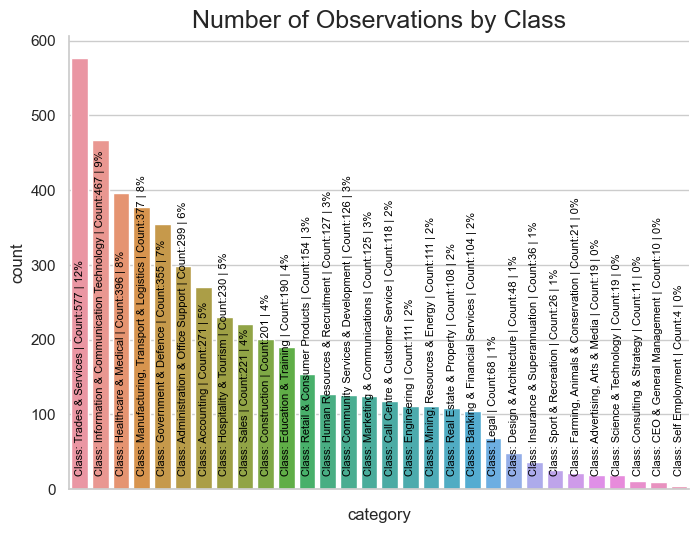

In [46]:
csv_path = "./data/seek_data_split.csv"
seek_data = pd.read_csv(csv_path)
if functions_to_run.visualize:
    class_counts = seek_data["category"].value_counts() 
    class_names = seek_data["category"].value_counts().index

    total_count = sum(seek_data["category"].value_counts())
    ## Set up annotation text 
    labels = []
    ## Loop through class counts and create annotation text 
    for id , class_count in enumerate(class_counts):
        label = "Class: {0} | Count:{1} | {2}".format( 
            class_names[id], 
            class_count, 
            "{0:.0%}".format(class_count / total_count) 
        )
        labels.append(
            label
        )
        ## Plot the frequency of the response variable 
    bar = sns.countplot(data=seek_data, 
                            x="category", 
                            order=seek_data["category"].value_counts().index 
                        )
        ## Set the title 
    x = bar.set_title("Number of Observations by Class" , fontsize=18)
    x = bar.set_xticklabels("",rotation = 90)

    ## Add annotation to plot 
    for i in range(len(seek_data["category"].value_counts())):
            value = seek_data["category"].value_counts()[i]
            x = bar.text(
                i,
                # value/2, 
                20, 
                labels[i], 
                fontdict=dict(color="black", fontsize=8), 
                rotation = 90,
                horizontalalignment="center" )
            


### Contract Type Balance 

Here there is still an imbalance, it is not as significant as in the job categories however some care will need to be taken when modeling. 

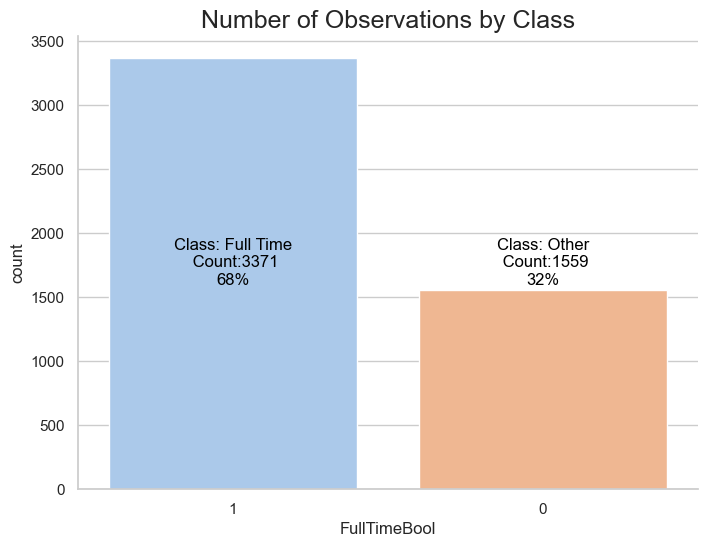

In [47]:
if functions_to_run.visualize:
    ## Get number of observations 
    class_counts = seek_data["FullTimeBool"].value_counts() 
    class_names = ["Full Time" , "Other"]

    total_count = sum(seek_data["FullTimeBool"].value_counts())

    ## Set up annotation text 
    labels = []

    ## Loop through class counts and create annotation text 
    for id , class_count in enumerate(class_counts):
        label = "Class: {0}\n Count:{1}\n{2}".format( 
            class_names[id], 
            class_count, 
            "{0:.0%}".format(class_count / total_count) 
        )
        labels.append(
            label
        )

    ## Plot the frequency of the response variable 
    bar = sns.countplot(data=seek_data, 
                        x="FullTimeBool", 
                        order=seek_data["FullTimeBool"].value_counts().index 
                    )
    ## Set the title 
    x = bar.set_title("Number of Observations by Class" , fontsize=18)

    ## Add annotation to plot 
    for i in range(len(seek_data["FullTimeBool"].value_counts())):
        value = seek_data["FullTimeBool"].value_counts()[i]
        x = bar.text(
            i,
            # value/2, 
            1600, 
            labels[i], 
            fontdict=dict(color='black', fontsize=12), 
            horizontalalignment='center' )
        

# Embeddings & TSNE

## Train Word Embeddings Word2Vec

In [10]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

def get_case_sentences_as_array(df):
    all_sentences = []
    for x_case_words in df.x_case_words:
        sentences = []
        for token in x_case_words.split(" "):
            sentences.append(token)
        all_sentences.append(sentences)
    return all_sentences

def create_gensim_embeddings(sentences, export=False , output_path= "", name =""):
    # train model
    model = Word2Vec(sentences, min_count=1)
    # save model 
    if export:
        model.save(f'{output_path}/{name}_model.bin')
    return model 

def display_closestwords_tsnescatterplot(model, word, dim):
    arr = np.empty((0,dim), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word.capitalize}', fontsize=18 )
    plt.show()
    

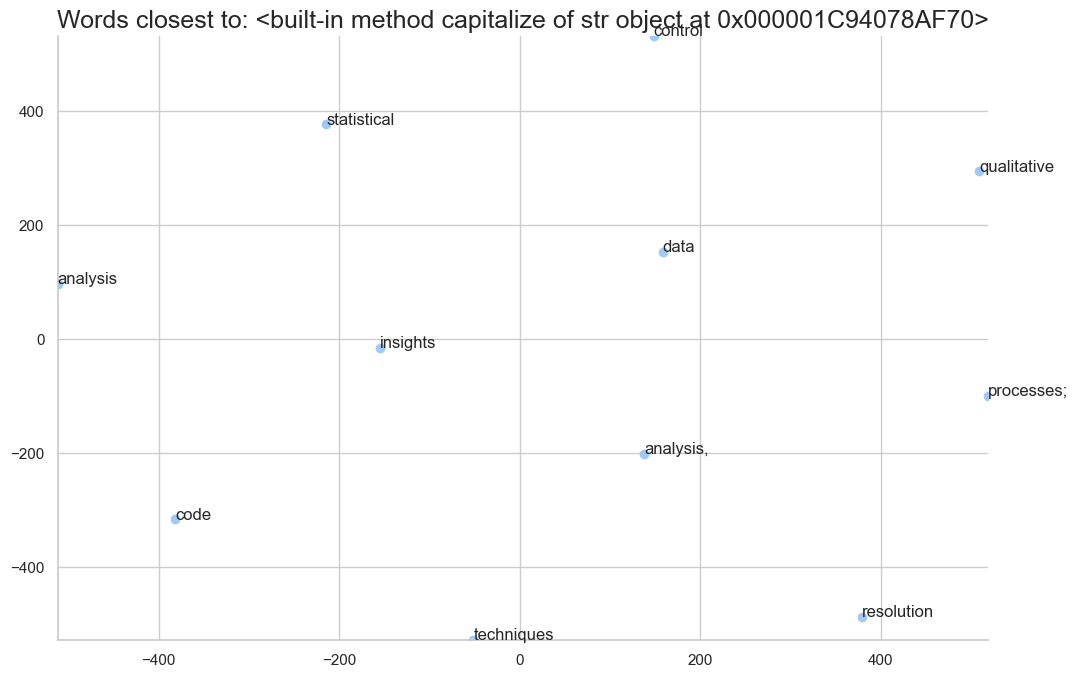

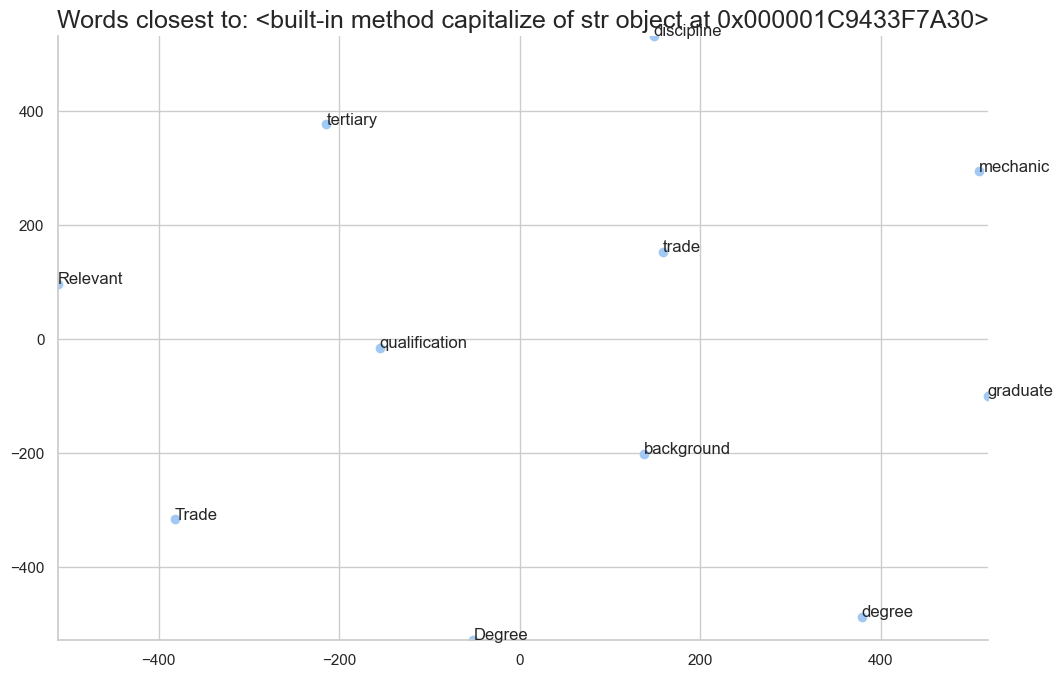

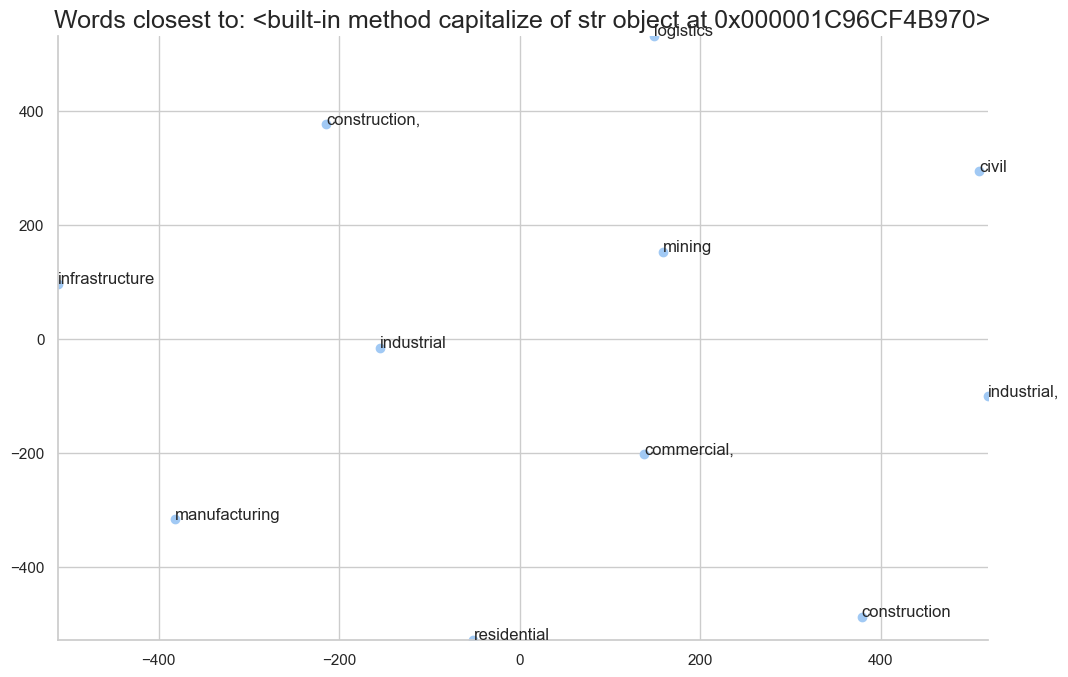

In [11]:
if functions_to_run.train_embedding_and_tsne:
    name = ""
    path = ""
    output_path = ""
    csv_path = "./data/seek_data/seek_data_binary_full_des.csv"

    df = pd.read_csv(csv_path)
    sentences = get_case_sentences_as_array(df)
    model = create_gensim_embeddings(sentences, export=False)

    ## Plot embeddings 
    for word in ["data" , "trade", "mining"]:
        display_closestwords_tsnescatterplot(model,word, 100 )

# Task 1: Binary Document Classification

#### Setup Utilities

In [12]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        

## Select Model & Data Type

Use the values below to select what model, data type and word embeddings you wish to use for the modeling phase. 

Note: Lists indexes are 0 based.

For Example: 

Selecting:
- model 1, data_index 1, & embedding index 2 

Would return: 
- 'GRU' for the top ten 'filtered words' using the domain trained 'Word2Vector' embeddings 

In [17]:
## Select model, Vectorization, and data type 
model_index = 1
data_index= 1
embedding_index= 2

## Options to choose from 
models = ["MLP", "CNN"]
data_types = ["full_des" , "filterd_words"]
embedding_types = ["OneHot" , "GloVe" , "Word2Vec"]

In [18]:
## Setup functions 
def select_model():
    return models[model_index]

def select_processed_data_type():
    return data_types[data_index]

def select_embedding():
    return embedding_types[embedding_index]

def set_csv_path():
    # return f"data/ag_seek/{data_types[data_index]}/seek_with_splits.csv" 
    return f"data/seek_data/seek_data_binary_{data_types[data_index]}.csv" 

def set_model_output_location():
    return f"model_storage/{models[model_index]}/{data_types[data_index]}"


## Key Arguments 

Below are some of the key modeling & workflow parameters. I have made an effort to try to ensure that most values can be set here rather than later on in the code. 


In [19]:
args = Namespace(
    # Model Selections
    model = select_model(),
    embedding_type = select_embedding(),
    data_set = select_processed_data_type(),
    save_embeddings = False,
    save_model = False,
    
    # Data and Path hyper parameters
    seek_csv= set_csv_path(),
    save_dir=set_model_output_location(),
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    
    # Model hyper parameters
    glove_filepath='data/glove/glove.6B.100d.txt', 
    trained_embed_filepath="data/trained_embeddings/model.bin", 
    embedding_size=100, 
    hidden_dim=100, 
    num_channels=100, 
    
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.1, 
    batch_size=128, 
    num_epochs=100, 
    early_stopping_criteria=5, 

    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)




Expanded filepaths: 
	model_storage/CNN/filterd_words\vectorizer.json
	model_storage/CNN/filterd_words\model.pth
Using CUDA: False


## PyTorch Setup Functions 

### Data Vectorization classes

#### The Vocabulary

In [20]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [21]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

#### The Vectorizer

In [22]:
class SeekVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, x_case_words, vector_length=-1):
        """
        Args:
            x_case_words (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized x_case_words (numpy.array)
        """
        
        indices = [self.title_vocab.begin_seq_index]
        indices.extend(self.title_vocab.lookup_token(token) 
                       for token in x_case_words.split(" "))
        indices.append(self.title_vocab.end_seq_index)


        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, seek_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            seek_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the SeekVectorizer
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(seek_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for x_case_words in seek_df.x_case_words:
            for token in x_case_words.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = \
            SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab =  \
            Vocabulary.from_serializable(contents['category_vocab'])

        return cls(title_vocab=title_vocab, category_vocab=category_vocab)

    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

#### The Dataset

In [23]:
class SeekDataset(Dataset):
    def __init__(self, seek_df, vectorizer):
        """
        Args:
            seek_df (pandas.DataFrame): the dataset
            vectorizer (SeekVectorizer): vectorizer instatiated from dataset
        """
        self.seek_df = seek_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, seek_df.x_case_words)) + 2
        
        self.train_df = self.seek_df[self.seek_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.seek_df[self.seek_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.seek_df[self.seek_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = seek_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, seek_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            Seek_csv (str): location of the dataset
        Returns:
            an instance of SeekDataset
        """
        seek_df = pd.read_csv(seek_csv , error_bad_lines=True)
        train_seek_df = seek_df[seek_df.split=='train']
        return cls(seek_df, SeekVectorizer.from_dataframe(train_seek_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, seek_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            seek_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SeekDataset
        """
        seek_df = pd.read_csv(seek_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(seek_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SeekVectorizer
        """
        with open(vectorizer_filepath, errors='ignore') as fp:
            return SeekVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath,  "w", errors='ignore' ) as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        title_vector = \
            self._vectorizer.vectorize(row.x_case_words, self._max_seq_length)

        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': title_vector,
                'y_target': category_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Make Embeddings Functions 

In [24]:
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r" , errors='ignore') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

def make_trained_embedding_matrix(embeddings_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        embeddings_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    ##
    from gensim.models import Word2Vec
    # load model
    loaded_model = Word2Vec.load(embeddings_filepath) 
    X = loaded_model[loaded_model.wv.vocab]
    embedding_size = X.shape[1]
    final_embeddings = np.zeros((len(words), embedding_size))
    for i, word in enumerate(words):
        if word in loaded_model.wv.vocab:
            final_embeddings[i, :] = loaded_model[word]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

## The Model: SeekClassifier


#### MLP

In [25]:
class SeekClassifier_MLP(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p,  
                 pretrained_embeddings=None, input_dim=12 , padding_idx=0, ):
    # def __init__(self,input_dim, hidden_dim, output_dim):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(SeekClassifier_MLP, self).__init__()
        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),            
            nn.Softmax(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )
        


    def forward(self, x_in, apply_softmax=False):
    # def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
                apply_softmax (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """      
        x = self.flatten(x_in)
        y_out = self.linear_relu_stack(x)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

#### CNN

In [26]:
     
class SeekClassifier_CNN(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p,  
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(SeekClassifier_CNN, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                #    out_channels=num_channels, kernel_size=3),
                   out_channels=num_channels, kernel_size=1),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                #    kernel_size=3, stride=2),
                   kernel_size=1, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                #    kernel_size=3, stride=2),
                   kernel_size=1, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=1),
                #    kernel_size=3),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training Routine

### Training Setup functions

In [27]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria
        ## Save Embeddings 
        if args.save_embeddings:
            save_embeddings(embeddings)

    return train_state


embedding_path = f"./{args.save_dir}/{args.data_set}_embeddings.txt" 
 

def save_embeddings(embeddings):
    if embeddings is None: 
        return
    with open(embedding_path , "w") as f:
          f.write(json.dumps(embeddings.tolist()))

def load_embeddings(path):
    #Now read the file back into a Python list object
    with open(path, 'r') as f:
        a = json.loads(f.read())
        return np.array(a)


### Initializations & Embedding Selection

In [28]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SeekDataset.load_dataset_and_load_vectorizer(args.seek_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SeekDataset.load_dataset_and_make_vectorizer(args.seek_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

## Select the embeddings type 
if args.embedding_type == "GloVe":
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
elif args.embedding_type == "Word2Vec":
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_trained_embedding_matrix(args.trained_embed_filepath, 
                                       words=words)
    print("Using trained embeddings")
else:
    print("Using one-hot embeddings")
    embeddings = None


Using trained embeddings


### Model Selection

In [29]:

if args.model == "MLP":
    print_heading( " USING MLP MODEL " )
    classifier = SeekClassifier_MLP(embedding_size=args.embedding_size, 
                                num_embeddings=len(vectorizer.title_vocab),
                                num_channels=args.num_channels,
                                hidden_dim=args.hidden_dim, 
                                num_classes=len(vectorizer.category_vocab), 
                                dropout_p=args.dropout_p,
                                pretrained_embeddings=embeddings,
                                padding_idx=0,
                                input_dim=12)
    
elif args.model == "CNN":
    print_heading( " USING CNN MODEL " )
    classifier = SeekClassifier_CNN(embedding_size=args.embedding_size, 
                                num_embeddings=len(vectorizer.title_vocab),
                                num_channels=args.num_channels,
                                hidden_dim=args.hidden_dim, 
                                num_classes=len(vectorizer.category_vocab), 
                                dropout_p=args.dropout_p,
                                pretrained_embeddings=embeddings,
                                padding_idx=0)
classifier.state_dict

----------------------------------------------------------------------------------------------------
                                          USING CNN MODEL 
---------------------------------------------------------------------------------------------------- 



<bound method Module.state_dict of SeekClassifier_CNN(
  (emb): Embedding(486, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(1,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(1,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>

### Training loop

#### MLP Training Loop 

In [30]:
def compute_accuracy(y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100

In [31]:
if args.model == "MLP":

    classifier = classifier.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                    mode='min', factor=0.5,
                                                    patience=1)
    
    train_state = make_train_state(args)

    epoch_bar = tqdm_notebook(desc='training routine', 
                            total=args.num_epochs,
                            position=0)

    dataset.set_split('train')
    train_bar = tqdm_notebook(desc='split=train',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)
    dataset.set_split('val')
    val_bar = tqdm_notebook(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()
                
                # step 2. compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())
                # y_pred = classifier(x_in=batch_dict['x_data'])

                # step 3. compute the loss
                # loss = loss_func(y_pred, batch_dict['y_target'].float())
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, 
                                    acc=running_acc, 
                                    epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                
                val_bar.set_postfix(loss=running_loss, 
                                    acc=running_acc, 
                                    epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()

            if train_state['stop_early']:
                break

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")

In [32]:
if args.model == "MLP":
    # compute the loss & accuracy on the test set using the best available model
    classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = classifier.to(args.device)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc

    print("Test loss: {:.3f}".format(train_state['test_loss']))
    print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

#### CNN Training Loop

In [ ]:

if args.model == "CNN":

    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
        
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)
    # loss_func = nn.BCEWithLogitsLoss (dataset.class_weights)
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                            mode='min', factor=0.5,
                                            patience=1)

    train_state = make_train_state(args)

    epoch_bar = tqdm_notebook(desc='training routine', 
                            total=args.num_epochs,
                            position=0)

    dataset.set_split('train')
    train_bar = tqdm_notebook(desc='split=train',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)

    dataset.set_split('val')
    val_bar = tqdm_notebook(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on

            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()


                # step 2. compute the output
                y_pred = classifier(batch_dict['x_data'])

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                    epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  classifier(batch_dict['x_data'])

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")


In [34]:
if args.model == "CNN":
    # compute the loss & accuracy on the test set using the best available model

    classifier.load_state_dict(torch.load(train_state['model_filename']))

    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'])
        
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    print("Test loss: {};".format(train_state['test_loss']))
    print("Test Accuracy: {}".format(train_state['test_acc']))

<All keys matched successfully>

SeekClassifier_CNN(
  (emb): Embedding(486, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(100, 100, kernel_size=(1,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(100, 100, kernel_size=(1,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

Test loss: 0.7296294825417655;
Test Accuracy: 62.611607142857146


## Model Metrics 

### Setup Functions 

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score , accuracy_score
from sklearn.metrics import confusion_matrix 

## Set the size of the plots 
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # Note: 200 e.g. is really fine, but slower

## Setup data fields 
class_names = ["Other", "Full Time"]

## Function that creates a confusion matrix plot 
def create_confusion_plot(conf_mx , y_values , name =""):
  ## Format the value from matrix
  group_counts = ["{0:0.0f}".format(value) for value in
                  conf_mx .flatten()]
                  
  ## Get the percentage of represented in each cell
  group_percentages = ["{0:.2%}".format(value) for value in
                      conf_mx .flatten()/np.sum(conf_mx )]
  ## Create Text Labels 
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]

  ## Reshape the array into a data frame 
  n_classes = len(np.unique(y_values))
  labels = np.asarray(labels).reshape(n_classes , n_classes)

  ## Create colour palette
  cmap = 'Blues'

  ## Create new plot
  plt.figure() 
  ## Create heatmap
  # res = sns.heatmap(conf_mx , annot=labels ,fmt='',  vmin=0.0, vmax= 100.0,  cmap=cmap)
  res = sns.heatmap(conf_mx , annot=labels ,fmt='',     cmap=cmap)

  # labels, title and ticks
  res.set_xlabel('Predicted labels')
  res.set_ylabel('True labels')
  res.set_title(name + " Class Confusion Matrix", fontsize=18)
  res.xaxis.set_ticklabels( [class_names[i] for i in  np.unique(y_values)] )
  res.yaxis.set_ticklabels([class_names[i] for i in  np.unique(y_values)] )
  plt.yticks(rotation=0) 
  plt.plot()

## Function to quickly create model evaluations 
def evaluate_torch_model(y_target, y_pred, name=""):
    # print("\n\n---------------------------- Model Results ----------------------------\n")
    # print_heading("Model Results")
    ## Create Prediction from testing data 
    # y_prob = model.predict(x_data)
    # y_pred = y_prob.argmax(axis=-1)

    ## Calculate individual scores
    print(name , " Accuracy Score: " , "{0:.2%}".format(accuracy_score(y_target, y_pred)))
    print(name , " Precision Score: " , "{0:.2%}".format(precision_score(y_target, y_pred, average="weighted")))
    print(name , " Recall Score: " , "{0:.2%}".format(recall_score(y_target, y_pred, average="weighted")))
    print(name , " F1 Score: " , "{0:.2%}".format(f1_score(y_target, y_pred, average="weighted")))

    ## Classification performance 
    report = classification_report(y_target, y_pred)
    print_heading("Classification Report")
    print(report)

    ## Create confusion matrix - no need to print as its on the plot
    conf_mx = confusion_matrix( y_target , y_pred )
    print_heading("Confusion Matrix")
    create_confusion_plot(conf_mx , y_target,  name )

def influential_words(model , number, reverse , model_name=""):
    # Sort weights
    fc1_weights = model.fc1.weight.to('cpu').detach()[0]
    _, indices = torch.sort(fc1_weights, dim=0, descending=True)
    indices = indices.numpy().tolist()
    direction = "Positive"
    if reverse:
      indices.reverse
      direction = "Negative"
    print_heading(f"{model_name} Influential Words in {direction} Reviews:")
    for i in range(number):
        print(vectorizer.title_vocab.lookup_index(indices[i]))

# Model Comparisons 

## Loading & Utility Functions 

In [36]:
def get_text_length(path):
    df = pd.read_csv(path)
    return len(df[df.split == "test"])

def load_model_from_file(path):
    
    ## Get path & model information 
    model_name = path.split("/")[1]
    data_type = path.split("/")[2]
    model_path = path + "final_model.pth"
    csv_path = f"./data/seek_data/seek_data_binary_{data_type}.csv"

    ## Set Seed 
    meaning_of_life = 42
    np.random.seed(meaning_of_life)
    torch.manual_seed(meaning_of_life)

    # create dataset and vectorizer
    dataset = SeekDataset.load_dataset_and_make_vectorizer(csv_path)
    vectorizer = dataset.get_vectorizer()

    ## Load Embeddings 
    embeddings = load_embeddings(f"./{path}/{data_type}_embeddings.txt")
    
    if model_name == "MLP":
            classifier = SeekClassifier_MLP(embedding_size=args.embedding_size, 
                                    num_embeddings=len(vectorizer.title_vocab),
                                    num_channels=args.num_channels,
                                    hidden_dim=args.hidden_dim, 
                                    num_classes=len(vectorizer.category_vocab), 
                                    dropout_p=args.dropout_p,
                                    pretrained_embeddings=embeddings,
                                    padding_idx=0,
                                    input_dim=12)
            
            classifier.load_state_dict(torch.load(model_path))
            classifier = classifier.to(args.device)
            dataset.class_weights = dataset.class_weights.to(args.device)
            
            dataset.set_split('test')
            batch_generator = generate_batches(dataset, 
                                            batch_size=get_text_length(csv_path), 
                                            device=args.device)
            classifier.eval()
            for batch_index, batch_dict in enumerate(batch_generator):
                # compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())
                y_data = batch_dict['y_target'].detach().numpy()
                _, y_pred_indices = y_pred.max(dim=1)
                y_pred_indices = y_pred_indices.detach().numpy()


    elif model_name == "CNN":
        classifier = SeekClassifier_CNN(embedding_size=args.embedding_size, 
                                    num_embeddings=len(vectorizer.title_vocab),
                                    num_channels=args.num_channels,
                                    hidden_dim=args.hidden_dim, 
                                    num_classes=len(vectorizer.category_vocab), 
                                    dropout_p=args.dropout_p,
                                    pretrained_embeddings=embeddings,
                                    padding_idx=0)
        classifier.load_state_dict(torch.load(model_path))

        classifier = classifier.to(args.device)
        dataset.class_weights = dataset.class_weights.to(args.device)

        dataset.set_split('test')
        batch_generator = generate_batches(dataset, 
                                        batch_size=get_text_length(csv_path), 
                                        device=args.device)
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  classifier(batch_dict['x_data'])
                
            y_data = batch_dict['y_target'].detach().numpy()
            _, y_pred_indices = y_pred.max(dim=1)
            y_pred_indices = y_pred_indices.detach().numpy()

    
    print_heading( f"Model Outcomes: {model_name} {data_type}" )
    evaluate_torch_model(y_data, y_pred_indices, model_name)
                
    return classifier


## MLP: Top 10 Filtered TF-IDF Classification 

----------------------------------------------------------------------------------------------------
                                 Model Outcomes: MLP filterd_words
---------------------------------------------------------------------------------------------------- 

MLP  Accuracy Score:  55.48%
MLP  Precision Score:  61.94%
MLP  Recall Score:  55.48%
MLP  F1 Score:  57.01%
----------------------------------------------------------------------------------------------------
                                       Classification Report
---------------------------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.37      0.58      0.45       313
           1       0.73      0.54      0.63       673

    accuracy                           0.55       986
   macro avg       0.55      0.56      0.54       986
weighted avg       0.62      0.55      0.57       986

----------------------------

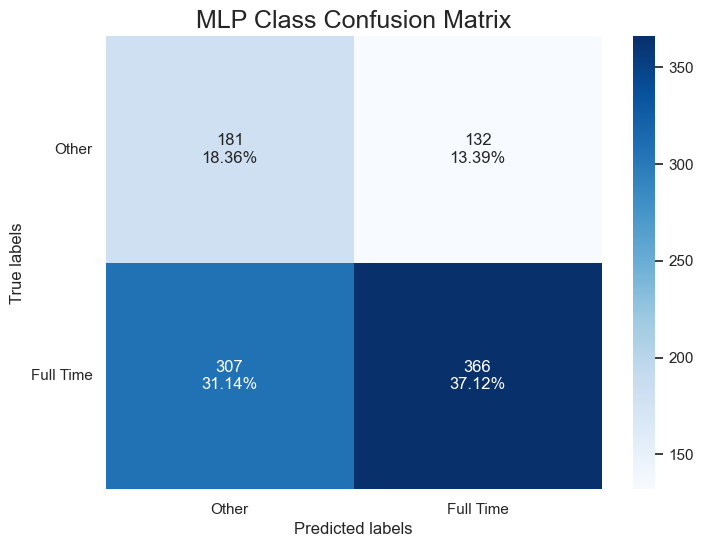

In [37]:
model = load_model_from_file("model_storage/MLP/filterd_words/")

## CNN: Top 10 Filtered TF-IDF Classification 

----------------------------------------------------------------------------------------------------
                                 Model Outcomes: CNN filterd_words
---------------------------------------------------------------------------------------------------- 

CNN  Accuracy Score:  59.33%
CNN  Precision Score:  63.00%
CNN  Recall Score:  59.33%
CNN  F1 Score:  60.53%
----------------------------------------------------------------------------------------------------
                                       Classification Report
---------------------------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.39      0.53      0.45       313
           1       0.74      0.62      0.68       673

    accuracy                           0.59       986
   macro avg       0.57      0.58      0.56       986
weighted avg       0.63      0.59      0.61       986

----------------------------

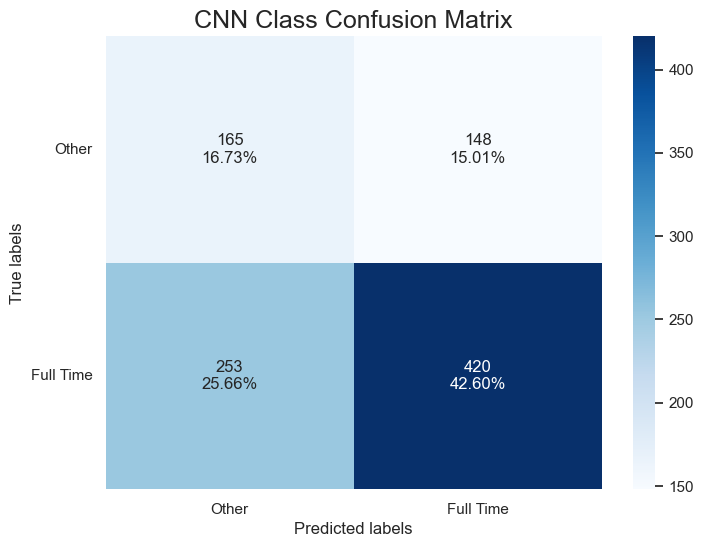

In [38]:
model = load_model_from_file("model_storage/CNN/filterd_words/")

## CNN: Full Description Classification 

----------------------------------------------------------------------------------------------------
                                    Model Outcomes: CNN full_des
---------------------------------------------------------------------------------------------------- 

CNN  Accuracy Score:  66.33%
CNN  Precision Score:  68.58%
CNN  Recall Score:  66.33%
CNN  F1 Score:  67.11%
----------------------------------------------------------------------------------------------------
                                       Classification Report
---------------------------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.48      0.58      0.52       313
           1       0.78      0.70      0.74       673

    accuracy                           0.66       986
   macro avg       0.63      0.64      0.63       986
weighted avg       0.69      0.66      0.67       986

------------------------------

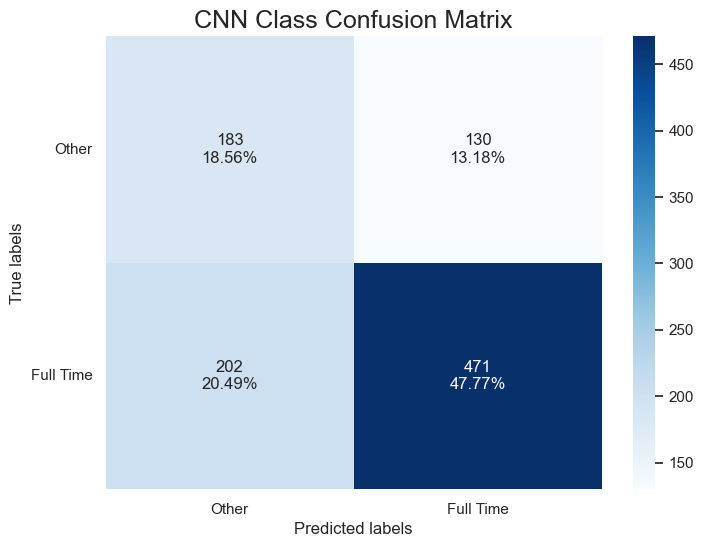

In [39]:
model = load_model_from_file("model_storage/CNN/full_des/")


## Most Influential Words 

In [40]:
influential_words(model, 10 , False , "CNN Full Description")
influential_words(model, 10 , True, "CNN Full Description")


----------------------------------------------------------------------------------------------------
                    CNN Full Description Influential Words in Positive Reviews:
---------------------------------------------------------------------------------------------------- 

so
support
established
looking
must
related
based
role
preparation
market
----------------------------------------------------------------------------------------------------
                    CNN Full Description Influential Words in Negative Reviews:
---------------------------------------------------------------------------------------------------- 

so
support
established
looking
must
related
based
role
preparation
market
